In [ ]:
!git clone https://github.com/vikalp026var/track_img.git

fatal: destination path 'track_img' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense,Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath
import random

In [ ]:
datadir='track_img'
columns=['center','left','right','steering','throttle','reverse','speed']
df=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
df.head()

<ipython-input-40-108ede7e0517>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg   

                                                                   left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg   

                                                                   right  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.649786  
1  0.0       0.0       0.0      0.627942  
2  0.0       0.0       0.0      0.622910  
3  0.0       0.0       0.0      0.619162  
4  0.0       0.0       0.0      0.615438

In [ ]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail

df['center']=df['center'].apply(path_leaf)
df['left']=df['left'].apply(path_leaf)
df['right']=df['right'].apply(path_leaf)
df.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

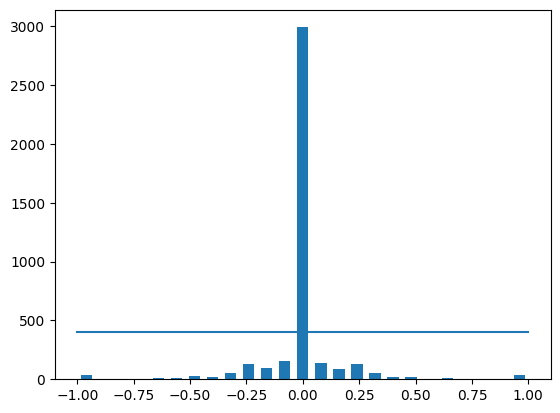

In [ ]:
num_bins=25
samples_per_bin=400
hist,bins=np.histogram(df['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
df.shape

(4053, 7)

In [ ]:
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(df['steering'])):
    if df['steering'][i]>=bins[j] and df['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:',len(remove_list))
df.drop(df.index[remove_list],inplace=True)
print('remaining:',len(df))



removed: 2590
remaining: 1463


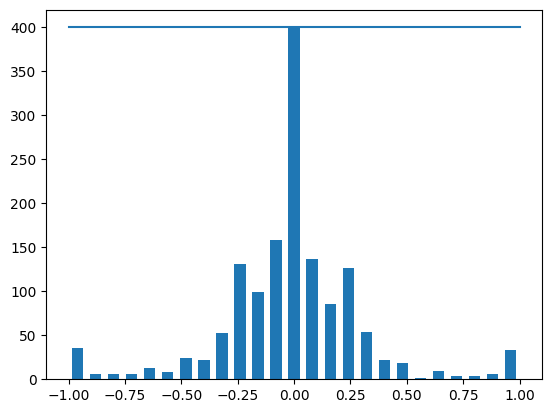

In [ ]:
num_bins=25
samples_per_bin=400
hist,bins=np.histogram(df['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths,steerings=load_img_steering(datadir + '/IMG',df)

In [ ]:
image_paths

array(['track_img/IMG/center_2018_07_16_17_11_43_670.jpg',
       'track_img/IMG/left_2018_07_16_17_11_43_670.jpg',
       'track_img/IMG/right_2018_07_16_17_11_43_670.jpg', ...,
       'track_img/IMG/center_2018_07_16_17_16_30_492.jpg',
       'track_img/IMG/left_2018_07_16_17_16_30_492.jpg',
       'track_img/IMG/right_2018_07_16_17_16_30_492.jpg'], dtype='<U48')

In [ ]:
len(steerings)

4389

In [ ]:
len(image_paths)

4389

In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2)

In [ ]:
len(X_train),len(X_valid)

(3511, 878)

Text(0.5, 1.0, 'Validation set')

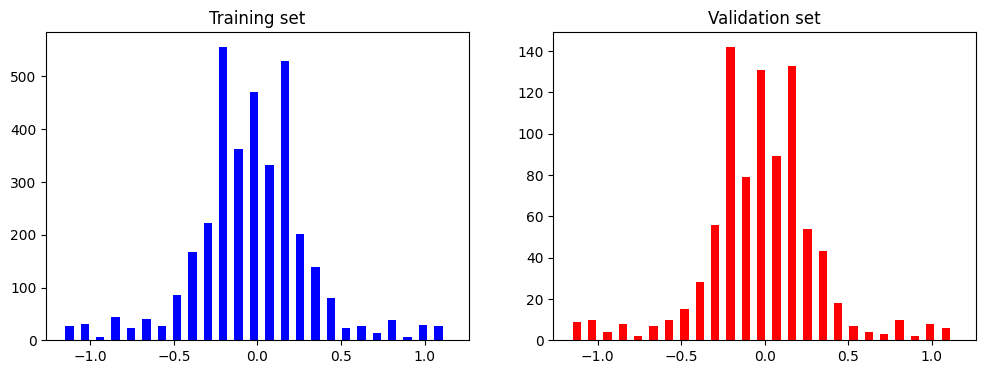

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')



Text(0.5, 1.0, 'Zoomed Image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle



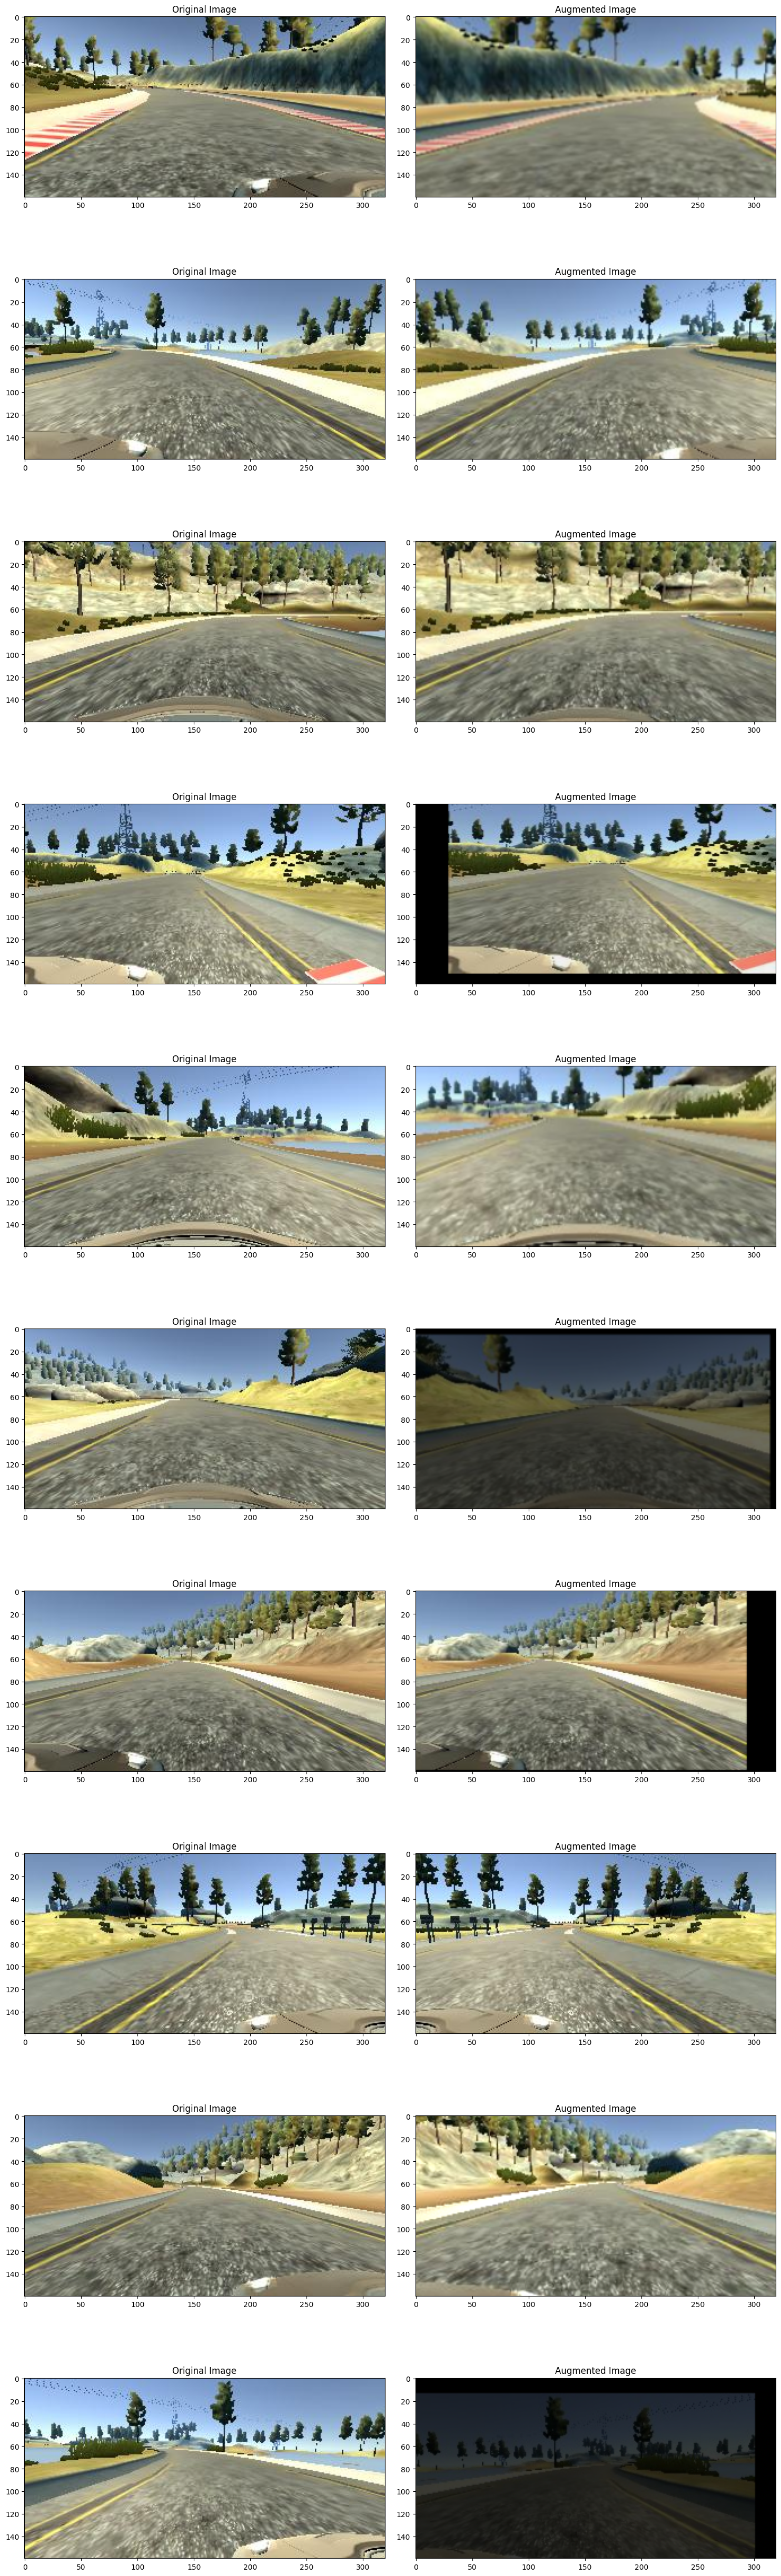

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
##Preprocessing

In [ ]:
def img_preprocessing(img):
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

In [ ]:
image=image_paths[100]
original_image=mpimg.imread(image)
preprocesses_image=img_preprocessing(original_image)

Text(0.5, 1.0, 'Preprocessed Image ')

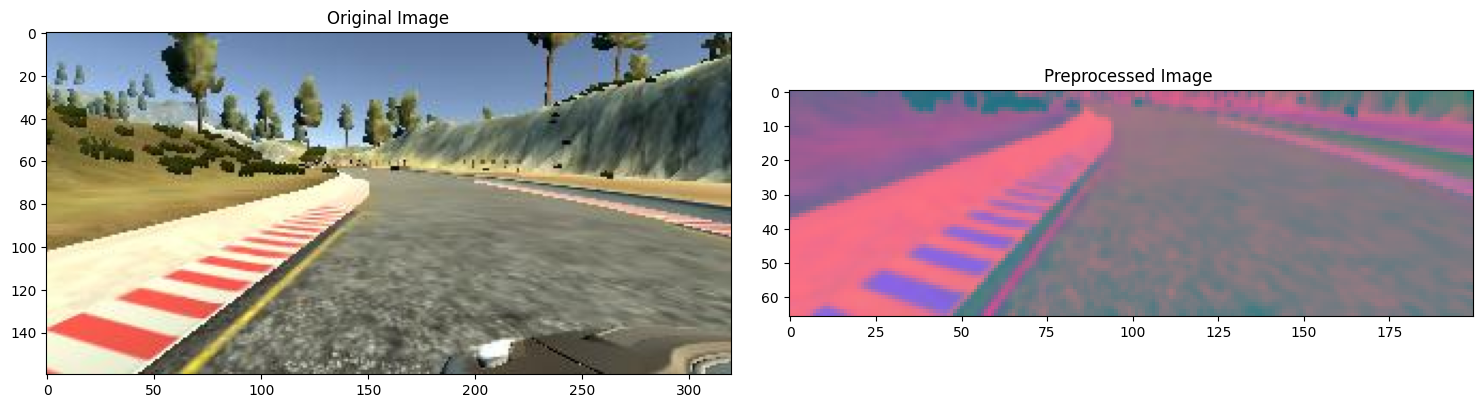

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocesses_image)
axs[1].set_title('Preprocessed Image ')

In [ ]:
!nvidia-smi

Fri Dec 29 15:46:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              27W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

NameError: ignored

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image ')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,BatchNormalization

In [ ]:
def nvidia_model():
  model=Sequential()
  model.add(Conv2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(48,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(64,(5,5),strides=(2,2),activation='elu'))
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1))
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model

model=nvidia_model()
model.summary()



In [ ]:
history=model.fit_generator(batch_generator(X_train,y_train,100))